In [ ]:
!pip install -r requirements.txt

In [ ]:
from sklearn.model_selection import train_test_split
from transformers import (AutoModelForCausalLM, AutoTokenizer, set_seed, Trainer, DataCollatorWithPadding,
                            TrainingArguments, AutoModelForSequenceClassification, CamembertTokenizer)
from datasets import Dataset
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np
import json
import torch.nn as nn
import evaluate
from sklearn.metrics import confusion_matrix
import seaborn as sns

from data_generation import generation

## **VISUALISATION DES DONNEES**

In [10]:
data = pd.read_csv('./data/intent-detection-train.csv')

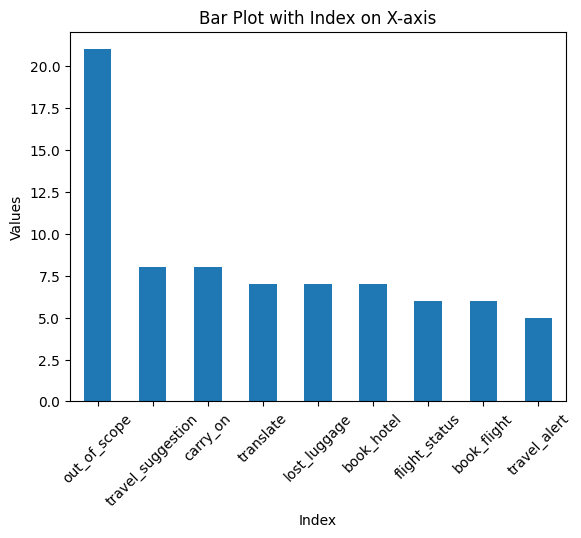

In [5]:
plt.figure()
data['label'].value_counts().plot(kind='bar')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Bar Plot with Index on X-axis')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()

In [6]:
X_train, X_test= train_test_split(data, test_size=0.5, stratify=data['label'], random_state=42)


In [7]:
classes = ['book_flight', 'book_hotel', 'carry_on', 'flight_status',
   'lost_luggage', 'translate', 'travel_alert',
   'travel_suggestion', 'out_of_scope']

In [145]:
mapping = {classe: idx for idx,classe in enumerate(classes)} 
reverse_mapping = {idx:classe for idx,classe in enumerate(classes)} 

In [95]:
def plot_confusion_matrix(true_val, pred):
    # Replace these with your predicted and true values

    # Get the confusion matrix
    cm = confusion_matrix(true_val, pred)
    
    # Display the confusion matrix as a heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

### **KNN with Sentence Embedding and Cosine Similarity**

In [47]:
from sentence_transformers import SentenceTransformer
model_embedding = SentenceTransformer('sentence-transformers/LaBSE')


In [48]:
intent_phrases = [
    "book_flight: l’utilisateur souhaite réserver un vol",
    "book_hotel: l’utilisateur souhaite réserver un hôtel",
    "carry_on: l'utilisateur souhaite des informations sur les bagages à main",
    "flight_status: l’utilisateur demande des informations sur le statut de son vol",
    "lost_luggage: l’utilisateur signale la perte de ses bagages",
    "translate: l’utilisateur souhaite traduire une phrase dans une autre langue",
    "travel_alert: l’utilisateur demande si sa destination est concernée par une alerte de voyage",   
    "travel_suggestion: l’utilisateur souhaite une recommandation de voyage"   
    ]


In [55]:
def evaluate_knn(X_test):
    y_test= list(X_test['label'])
    embedding_test = model_embedding.encode(list(X_test["text"]))

    intent_embedding = model_embedding.encode(intent_phrases)

    norms_test = np.linalg.norm(embedding_test, axis=1, ord=2).reshape(-1,1)
    norms_intent = np.linalg.norm(intent_embedding, axis=1, ord=2).reshape(-1,1)
    
    embedding_test = embedding_test/norms_test
    intent_embedding = intent_embedding/norms_intent
    
    out = np.mean(intent_embedding, axis = 0)
    out = out/np.linalg.norm(out, ord=2)

    sim = embedding_test@intent_embedding.T
    sim_out = embedding_test@out.T

    first = np.argmax(sim, axis= 1)
    values = np.max(sim, axis = 1)
    predictions= [first[i] if values[i] > sim_out[i] else 8 for i in range(len(first))]
    true_values = [mapping[elt] for elt in y_test]
    return predictions, true_values

In [97]:
predictions, true_values= evaluate_knn(X_test)

In [98]:
predictions = np.array(predictions)
true_values = np.array(true_values)
print(f"Accuracy :{np.mean(1.0*(predictions == true_values))}")

Accuracy :0.5526315789473685


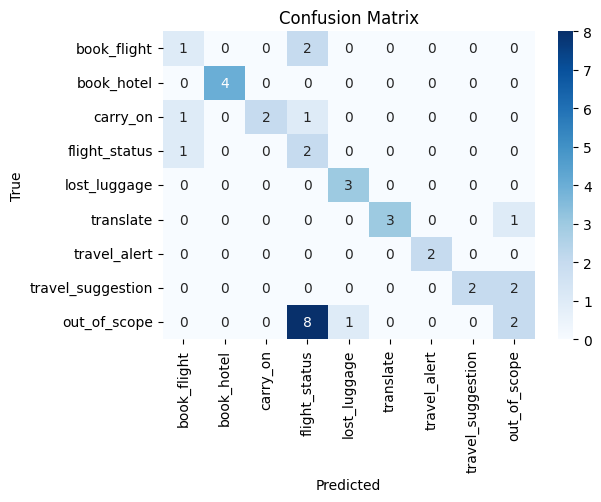

In [99]:
plot_confusion_matrix(true_values, predictions)

## **Mistral 7B Zero Shot QCM**

In [103]:
def prepare_qcm(text):
    introduction = "Un utilisateur d'un chat pour une agence de tourisme envoie le texte suivant: "
    proposition = "\nA. translate: l’utilisateur souhaite traduire une phrase dans une autre langue\nB. travel_alert: l’utilisateur demande si sa destination est concernée par une alerte de voyage\nC. flight_status: l’utilisateur demande des informations sur le statut de son vol\nD. lost_luggage: l’utilisateur signale la perte de ses bagages\nE. travel_suggestion: l’utilisateur souhaite une recommandation de voyage\nF. carry_on: l'utilisateur souhaite des informations sur les bagages à main\nG. book_hotel: l’utilisateur souhaite réserver un hôtel\nH. book_flight: l’utilisateur souhaite réserver un vol\nI. out_of_scope: l’utilisateur formule une demande qui n’appartient à aucune des 8 classes ci-dessus"
    return introduction + text + "\nQuelle est l'intention de sa requête ?" +  proposition + "\nAnswer: "

In [79]:
checkpoint_mistral = "mistralai/Mistral-7B-v0.1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_mistral = AutoModelForCausalLM.from_pretrained(checkpoint_mistral, torch_dtype=torch.bfloat16)

tokenizer_mistral = AutoTokenizer.from_pretrained(checkpoint_mistral)

model_mistral = model_mistral.to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [92]:
propositions = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
map_token = {}
for elt in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']:
    token = tokenizer_mistral(elt)['input_ids'][1]
    map_token[elt] = token

map_label = {'A': 'translate',
             'B': 'travel_alert',
             'C': 'flight_status',
             'D': 'lost_luggage',
             'E': 'travel_suggestion',
             'F': 'carry_on',
             'G': 'book_hotel',
             'H': 'book_flight',
             'I': 'out_of_scope'}

In [104]:
def predict_zero_shot(text):
    text = prepare_qcm(text)
    input_ids = tokenizer_mistral(text, return_tensors="pt").to(device)
    outputs = model_mistral(**input_ids)
    outputs = outputs.logits.detach()
    score = -float('inf')
    for k,v in map_token.items():
        current_score = outputs[:,-1,v].item()
        if score < current_score:
            score = current_score
            ans = map_label[k]
    return ans

In [105]:
def evaluate_zero_shot(X_test):
    score = 0
    predictions = []
    true_values = []
    for index in X_test.index:
        to_evaluate = X_test.loc[index]
        text = to_evaluate['text']
        label = to_evaluate['label']
        pred = predict_zero_shot(text)
        score += pred == label
        predictions.append(pred)
        true_values.append(label)
        if pred != label:
            print(f'text: {text}, prediction: {pred}, label: {label}')
    print(f'Accuracy : {score/len(X_test)}') 
    return predictions, true_values

In [106]:
predictions, true_values = evaluate_zero_shot(X_test)

text: Que puis-je faire à Nashville, prediction: out_of_scope, label: travel_suggestion
text: Quelle est la compagnie aérienne la plus populaire, prediction: book_flight, label: out_of_scope
text: Où est la meilleure cave du sud de la France, prediction: out_of_scope, label: travel_suggestion
text: Veuillez me dire comment demander un taxi en français, prediction: out_of_scope, label: translate
text: Pouvez-vous me dire comment dire «je ne parle pas beaucoup espagnol», en espagnol, prediction: out_of_scope, label: translate
Accuracy : 0.868421052631579


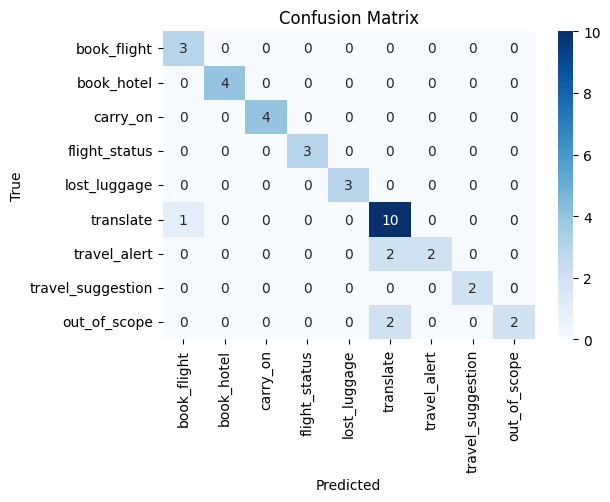

In [107]:
plot_confusion_matrix(true_values, predictions)

## **Mistral 7B few shot**

In [43]:
checkpoint_mistral = "mistralai/Mistral-7B-v0.1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_mistral = AutoModelForCausalLM.from_pretrained(checkpoint_mistral, torch_dtype=torch.bfloat16)

tokenizer_mistral = AutoTokenizer.from_pretrained(checkpoint_mistral)

model_mistral = model_mistral.to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [108]:
#nb_samples_by_class= 1
#x_train_prompt = X_train.groupby('label').apply(lambda x: x.sample(nb_samples_by_class)).reset_index(level = 0, drop = True)
#prompt = '\n\n'.join(x_train_prompt.apply(lambda x : 'text: ' + x['text'] + '\nlabel: ' + x['label'], axis = 1 ))
prompt = '\n\n'.join(X_train.apply(lambda x : 'text: ' + x['text'] + '\nlabel: ' + x['label'], axis = 1 ))

In [109]:
introduction = "Des utilisateurs d'un chat pour une agence de tourisme envoient dont il faut déterminer les intentions. Parmis Les différentes intentions sont les suivantes:\n"
proposition = "\nA. translate: l’utilisateur souhaite traduire une phrase dans une autre langue\nB. travel_alert: l’utilisateur demande si sa destination est concernée par une alerte de voyage\nC. flight_status: l’utilisateur demande des informations sur le statut de son vol\nD. lost_luggage: l’utilisateur signale la perte de ses bagages\nE. travel_suggestion: l’utilisateur souhaite une recommandation de voyage\nF. carry_on: l'utilisateur souhaite des informations sur les bagages à main\nG. book_hotel: l’utilisateur souhaite réserver un hôtel\nH. book_flight: l’utilisateur souhaite réserver un vol\nI. out_of_scope: l’utilisateur formule une demande qui n’appartient à aucune des 8 classes ci-dessus"
prompt = introduction + proposition + "\nVoici quelques exemples\n" + prompt

In [110]:
print(prompt)

Des utilisateurs d'un chat pour une agence de tourisme envoient dont il faut déterminer les intentions. Parmis Les différentes intentions sont les suivantes:

A. translate: l’utilisateur souhaite traduire une phrase dans une autre langue
B. travel_alert: l’utilisateur demande si sa destination est concernée par une alerte de voyage
C. flight_status: l’utilisateur demande des informations sur le statut de son vol
D. lost_luggage: l’utilisateur signale la perte de ses bagages
E. travel_suggestion: l’utilisateur souhaite une recommandation de voyage
F. carry_on: l'utilisateur souhaite des informations sur les bagages à main
G. book_hotel: l’utilisateur souhaite réserver un hôtel
H. book_flight: l’utilisateur souhaite réserver un vol
I. out_of_scope: l’utilisateur formule une demande qui n’appartient à aucune des 8 classes ci-dessus
Voici quelques exemples
text: Comment dire «hôtel» en finnois
label: translate

text: Donnez-moi une liste de choses à faire à Orlando
label: travel_suggestion

In [111]:
def predict_few_shot(prompt, text):
    total_prompt = prompt + '\n\ntext: ' + text + '\nlabel: '
    input_ids = tokenizer_mistral(total_prompt, return_tensors="pt").to(model_finetuned.device)
    sample = model_mistral.generate(**input_ids, max_new_tokens = 6)
    result_string = tokenizer_mistral.decode(sample[0])
    result_string = result_string[len(total_prompt):]
    for classe in classes:
        if classe in result_string:
            return classe
    return 'out_of_scope'

In [112]:
predict_few_shot(prompt, text = "Que faire comme activité quand on a perdu sa valise ?")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'out_of_scope'

In [113]:
predict_few_shot(prompt, text = "j'ai acheté de nouvelles valises")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'out_of_scope'

In [115]:
def evaluate_few_shot(X_test):
    score = 0
    predictions = []
    true_values = []
    for index in X_test.index:
        to_evaluate = X_test.loc[index]
        text = to_evaluate['text']
        label = to_evaluate['label']
        pred = predict_few_shot(prompt, text)    
        score += pred == label
        predictions.append(pred)
        true_values.append(label)
        if pred != label:
            print(f'text: {text}, prediction: {pred}, label: {label}')
    print(f'Accuracy : {score/len(X_test)}') 
    return predictions, true_values

In [116]:
predictions, true_values = evaluate_few_shot(X_test)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

text: Où est la meilleure cave du sud de la France, prediction: out_of_scope, label: travel_suggestion


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Accuracy : 0.9736842105263158


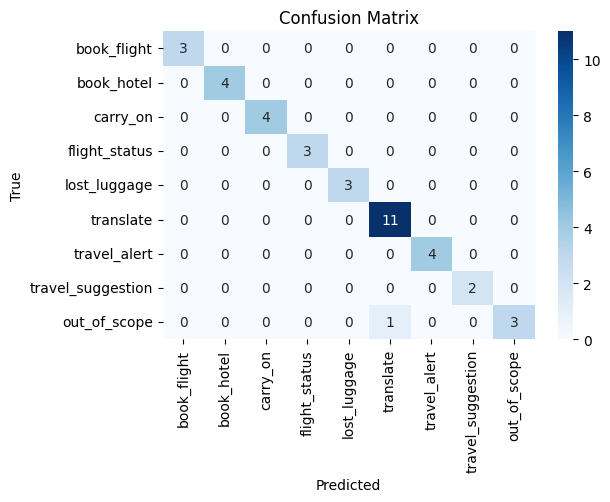

In [117]:
plot_confusion_matrix(true_values, predictions)

## **SELF INSTRUCT**

### **Generated Data**

In [11]:
df_generated = pd.read_csv('data/generated_data.csv')
#generation(X_train)

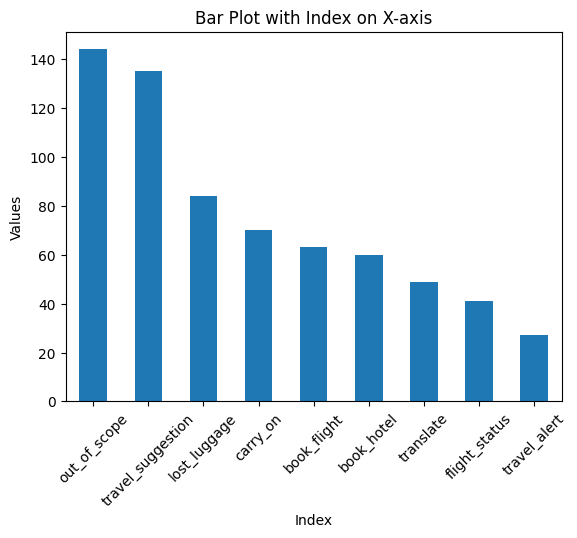

In [9]:
plt.figure()
df_generated['label'].value_counts().plot(kind='bar')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Bar Plot with Index on X-axis')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()

### **Model Training**

In [119]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        weight = [1.0 if elt != 'lost_luggage' else 2.0 for elt in classes]
        labels = inputs.pop("labels")
        device=model.device
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        #loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weight)).to(device)
        loss_fct = nn.CrossEntropyLoss().to(device)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [120]:
def compute_metrics(eval_preds):
    metric = evaluate.load("accuracy")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

def preprocessing(example):
    return tokenizer_finetuning(example["text"], truncation=True)

In [121]:
checkpoint_finetuned = 'almanach/camemberta-base' 

model_finetuned = AutoModelForSequenceClassification.from_pretrained(checkpoint_finetuned, num_labels=9)

tokenizer_finetuning = AutoTokenizer.from_pretrained("almanach/camemberta-base")

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at almanach/camemberta-base and are newly initialized: ['classifier.bias', 'pooler.dense.bias', 'classifier.weight', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [122]:
df_generated_new = df_generated.copy()
X_train_new = X_train.copy()
X_test_new = X_test.copy()

df_generated_new['label'] = df_generated_new.apply(lambda x: mapping[x["label"]], axis = 1)
X_train_new['label'] = X_train_new.apply(lambda x: mapping[x["label"]], axis = 1)
X_test_new['label'] = X_test_new.apply(lambda x: mapping[x["label"]], axis = 1)

train_set = Dataset.from_pandas(df_generated_new)
val_set=  Dataset.from_pandas(X_train_new)
test_set = Dataset.from_pandas(X_test_new)

train_set = train_set.map(preprocessing, batched=True)
val_set = val_set.map(preprocessing, batched=True)
test_set = test_set.map(preprocessing, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer_finetuning)


Map:   0%|          | 0/673 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Map:   0%|          | 0/38 [00:00<?, ? examples/s]

In [123]:
training_args = TrainingArguments(
    output_dir="./new_results/camembert_base",          # Output directory
    num_train_epochs=5,              # Number of training epochs
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs',
    logging_steps=50,  
    evaluation_strategy="steps",
    eval_steps=50,                  # Perform evaluation and log evaluation every 200 steps
)

In [124]:
trainer = CustomTrainer(
    model_finetuned,
    training_args,
    train_dataset=train_set,
    eval_dataset=val_set,
    data_collator=data_collator,
    tokenizer=tokenizer_finetuning,
    compute_metrics=compute_metrics
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [125]:
trainer.train()

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy
50,2.042400,1.907229,0.486486
100,1.490800,1.277899,0.783784
150,1.012600,0.960162,0.837838
200,0.625500,0.695629,0.918919
250,0.390600,0.591929,0.891892
300,0.227700,0.601038,0.864865
350,0.172400,0.546038,0.891892
400,0.130600,0.537770,0.891892


TrainOutput(global_step=425, training_loss=0.7236515824935016, metrics={'train_runtime': 42.8439, 'train_samples_per_second': 78.541, 'train_steps_per_second': 9.92, 'total_flos': 38314980909900.0, 'train_loss': 0.7236515824935016, 'epoch': 5.0})

In [39]:
eval_results = trainer.evaluate(eval_dataset=test_set)

In [132]:
print(f'Accuracy: {eval_results["eval_accuracy"]}')

Accuracy: 0.9210526315789473


### **Limites du modèle**

In [44]:
text = "j'ai acheté de nouvelles valises"
inputs = tokenizer_finetuning(text, return_tensors="pt").to(model_finetuned.device)
outputs = model_finetuned(**inputs)
logits = outputs.get("logits")
pred = torch.argmax(logits.view(-1, model_finetuned.config.num_labels)).item()
pred = reverse_mapping[pred]

print(pred)

lost_luggage
